<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

This notebook looks at the age / sex differences within cohorts.

In [1]:
# This block is just for importing the necessary libraries.  
import os
import pickle
from collections import defaultdict

# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis

from statsmodels.discrete.conditional_models import ConditionalLogit
from patsy import dmatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from logit import conditional_logistic_regression, clogit_predict
from plot import (rankplot, networkplot, vectorplot)
import random
import warnings

from q2_matchmaker._matching import _matchmaker


warnings.simplefilter('ignore')

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

In [2]:
david_md = pd.read_table('../sfari/data/sra/David2021/sample_metadata_JM-v2.txt', index_col=0)
#age_sex_matching = _matchmaker(david_md, 'Treatment', ['age_month_ok', 'Gender'], [False, True])
#age_sex_matching = age_sex_matching.astype(np.int64)
#david_md['Match_IDs'] = age_sex_matching
david_md['Age'] = david_md['age_month_ok'] / 12
david_md['Match_IDs'] = david_md['Pair']
david_md['Status'] = 'Treatment'

In [3]:
son_md = pd.read_table('../sfari/data/sra/Son2015/sample_metadata_JM-v2.txt', index_col=0)
son_md = son_md.dropna(subset=['Age', 'Sex'])
son_md = son_md.loc[son_md['Age'] > 0]
#age_sex_matching = _matchmaker(son_md, 'Status', ['Age', 'Sex'], [False, True])
#son_md['Match_IDs'] = age_sex_matching
#son_md = son_md.dropna(subset=['Match_IDs'])
#son_md['Match_IDs'] = son_md['Match_IDs'].astype(np.int64)
son_md['Match_IDs'] = son_md['Household']
son_md['Status'] = 'Diagnosis'

In [4]:
# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md_orig = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md_orig = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

In [5]:
for i, m in amp_md_orig.groupby('Cohort'):
    print(i, '\n', m.head()['Age'])

Berding2020 
 230B    3.0
110B    7.0
139B    4.0
108B    5.0
138B    4.0
Name: Age, dtype: float64
Chen2020 
 SRR12180466    4.0
SRR12180519    3.4
SRR12180512    4.7
SRR12180427    4.4
SRR12180597    4.6
Name: Age, dtype: float64
Dan2020 
 SRR9666980    3.0
SRR9666916    3.0
SRR9666817    6.0
SRR9666820    5.0
SRR9666768    8.0
Name: Age, dtype: float64
Fasano2020 
 SRR13306683    4.82
SRR13306701    6.52
SRR13306686    6.29
SRR13306687    5.86
SRR13306613    4.37
Name: Age, dtype: float64
Fouquier2021 
 ERR5263176    8.0
ERR5263110    4.0
ERR5263168    5.0
ERR5263171    6.0
ERR5263163    8.0
Name: Age, dtype: float64
Kang2017 
 SRR8798137     8.361111
SRR8798492     8.361111
SRR8798295    14.261111
SRR8798301    14.261111
SRR8798204    16.455556
Name: Age, dtype: float64
Zou2020 
 SRR10305381    4.0
SRR10305395    4.0
SRR10305374    6.0
SRR10305334    4.0
SRR10305409    4.0
Name: Age, dtype: float64
Zurita2019 
 P4.stool     12.0
P19.stool     8.0
P57.stool    10.0
P11.stool    12.0

Age differences

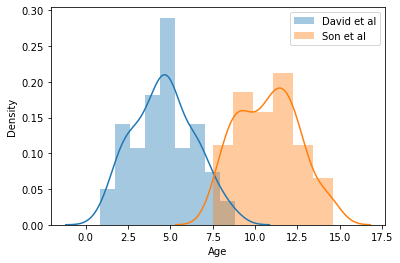

In [7]:
sns.distplot(david_md['Age'], label='David et al')
sns.distplot(son_md['Age'], label='Son et al')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

cols = ['Match_IDs', 'Age']

titles = ['16S', 'SMS', 'David et al', 'Son et al']
mds = [amp_md_orig, wgs_md_orig, david_md, son_md]
for i, md in enumerate(mds):
    md = md.sort_values(['Match_IDs', 'Status'])
    age_diffs = md[cols].groupby('Match_IDs').diff()['Age']
    age_diffs = age_diffs.dropna()
    #print(titles[i], 
    #      np.round(np.mean(age_diffs), 3),
    #      np.round(np.mean(age_diffs < 0), 3), 
    #      np.round(np.mean(age_diffs == 0), 3),
    #      np.round(np.mean(age_diffs > 0), 3))
    sns.histplot(age_diffs, ax=ax[i], binwidth=0.5)
    ax[i].set_title(titles[i])
    ax[i].set_xlim([-10, 10])
plt.tight_layout()

In [ ]:
submd = david_md[['Pair', 'Treatment', 'Age']]
submd = submd.groupby(['Pair']).filter(lambda x: len(x) == 2)
submd = submd.sort_values(['Pair', 'Treatment'])

In [ ]:
from scipy.stats import wilcoxon, ttest_rel
wilcoxon(submd.loc[submd['Treatment'] == 'Aut', 'Age'], submd.loc[submd['Treatment'] == 'Control', 'Age'])

In [ ]:
ttest_rel(submd.loc[submd['Treatment'] == 'Aut', 'Age'], submd.loc[submd['Treatment'] == 'Control', 'Age'])

Sex differences

In [ ]:
cols = ['Match_IDs', 'Sex']
amp_md = amp_md_orig.sort_values(['Match_IDs', 'Sex'])
f = lambda x: x.iloc[0]['Sex'] == x.iloc[1]['Sex']
sex_diffs = amp_md[cols].groupby('Match_IDs').apply(f)
sex_diffs.value_counts()

In [ ]:
cols = ['Match_IDs', 'Sex']
wgs_md = wgs_md_orig.sort_values(['Match_IDs', 'Sex'])
f = lambda x: x.iloc[0]['Sex'] == x.iloc[1]['Sex']
sex_diffs = wgs_md[cols].groupby('Match_IDs').apply(f)
sex_diffs.value_counts()

Sequencing depth differences

In [ ]:
amp_depths = pd.Series(amp_biom.sum(axis='sample'), 
                       index=amp_biom.ids(axis='sample'))
amp_md_orig['depth'] = amp_depths
amp_md_orig['log(depth)'] = np.log10(amp_depths)

In [ ]:
cols = ['Match_IDs', 'log(depth)']
amp_md = amp_md_orig.sort_values(['Match_IDs', 'log(depth)'])
depth_diffs = amp_md[cols].groupby('Match_IDs').diff()['log(depth)']
depth_diffs = depth_diffs.dropna()
sns.histplot(depth_diffs)

In [ ]:
np.exp(depth_diffs).mean()

In [ ]:
sns.histplot(np.log10(amp_depths))

In [ ]:
amp_depths.min()

In [ ]:
np.median(amp_depths)

In [ ]:
sns.boxplot(data=amp_md, x='Status', y='log(depth)')

In [ ]:
wgs_depths = pd.Series(wgs_biom.sum(axis='sample'), 
                       index=wgs_biom.ids(axis='sample'))
wgs_md_orig['depth'] = wgs_depths
wgs_md_orig['log(depth)'] = np.log10(wgs_depths)

In [ ]:
cols = ['Match_IDs', 'log(depth)']
wgs_md = wgs_md_orig.sort_values(['Match_IDs', 'log(depth)'])
depth_diffs = wgs_md[cols].groupby('Match_IDs').diff()['log(depth)']
depth_diffs = depth_diffs.dropna()
sns.histplot(depth_diffs)

In [ ]:
wgs_depths.min()

In [ ]:
np.mean(depth_diffs)

In [ ]:
sns.histplot(wgs_depths)

In [ ]:
sns.boxplot(data=wgs_md, x='Status', y='log(depth)')